In [4]:
import numpy as np
import pandas as pd
import datetime
import calendar
import seaborn as sns
from scipy import stats
from operator import attrgetter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from datetime import timedelta

# Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.


## 1 задание

Retention – один из самых важных показателей в компании. 
Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared 

**reg** - данные о времени регистрации

In [2]:
reg = pd.read_csv(f'shared/problem1-reg_data.csv',sep = ';') 

In [3]:
reg

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


**auth** - данные о времени захода пользователей в игру

In [4]:
auth = pd.read_csv(f'shared/problem1-auth_data.csv', sep = ';')

In [5]:
auth

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


совместим полученные датафреймы

In [6]:
df = auth.merge(reg, on = 'uid')

In [7]:
df

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089
...,...,...,...
9601008,1600874034,1110618,1600874034
9601009,1600874086,1110619,1600874086
9601010,1600874139,1110620,1600874139
9601011,1600874191,1110621,1600874191


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
 2   reg_ts   int64
dtypes: int64(3)
memory usage: 293.0 MB


***формула для расчета ретенш по дням***

In [41]:
def retention(start, end, days):
    
    reg = pd.read_csv(f'shared/problem1-reg_data.csv',sep = ';')
    auth = pd.read_csv(f'shared/problem1-auth_data.csv', sep = ';')
    #merge
    df = reg.merge(auth, on = 'uid', how = 'left')
    
    df['reg_ts'] = pd.to_datetime(df['reg_ts'], unit='s').dt.round('d')
    df['auth_ts'] = pd.to_datetime(df['auth_ts'], unit='s').dt.round('d')
    
    df['days'] = (df.auth_ts - df.reg_ts).dt.days.astype('int16')
    
    df = df.query('reg_ts >= @start and auth_ts <= @end')\
    .groupby(['reg_ts', 'days'], as_index=False).agg({'uid': 'nunique'})  
        
    df = df.pivot(index='reg_ts', columns='days', values='uid')
    cohort_sizes = df.iloc[:,0]
    retention = df.divide(cohort_sizes, axis=0).iloc[:-1, 1:]
    
    #  тепловой график   
    plt.figure(figsize=(22,16))
    plt.title("Retention Rate")
    sns.heatmap(data=retention,
           annot=True,
           fmt='.0%',
           vmin=0.0,
           vmax=0.3,
           cmap="BuGn")
    plt.show()
    return retention
    

**тест**

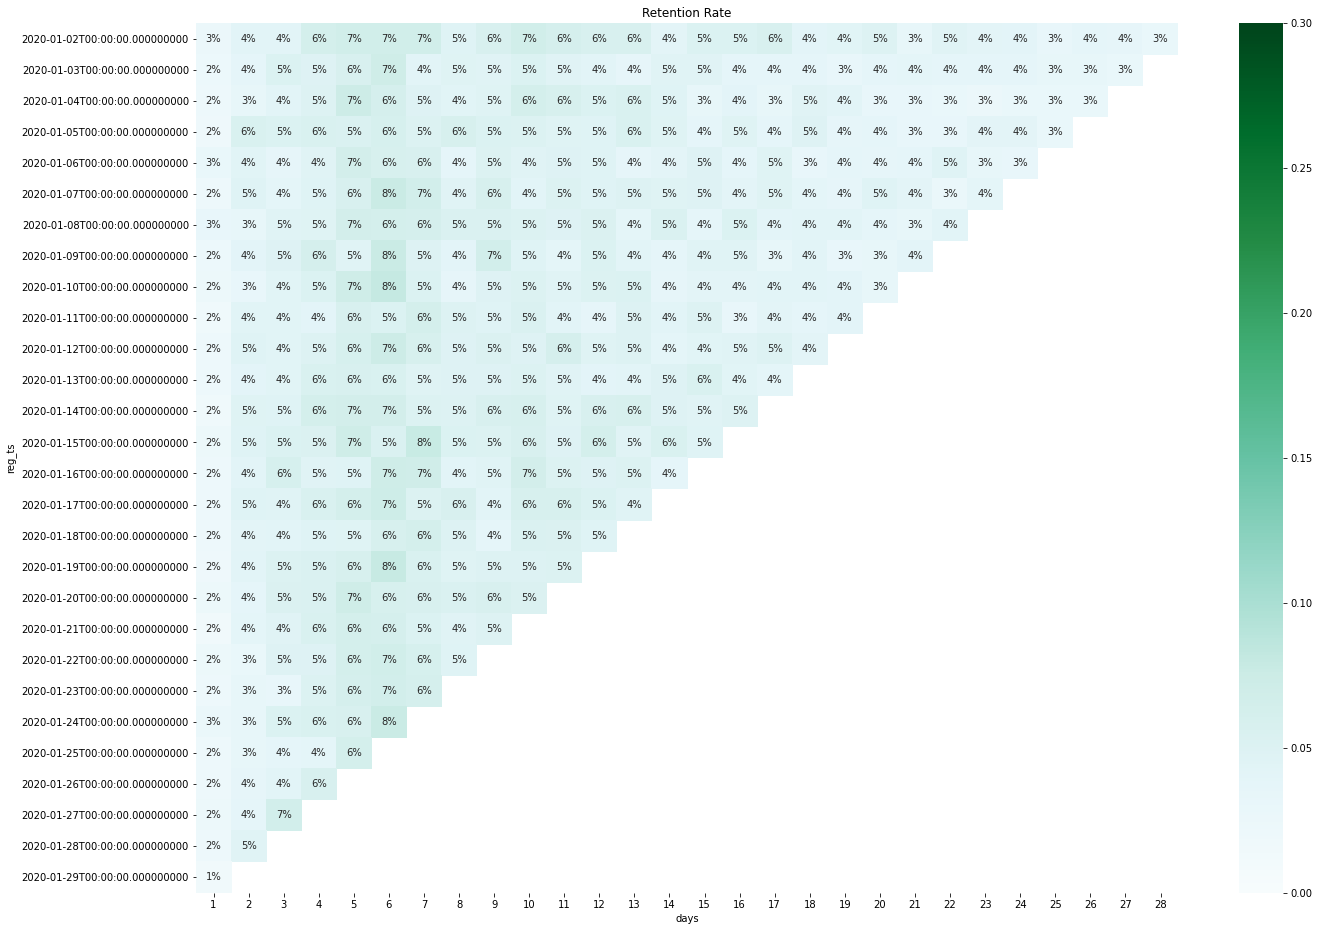

days,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.026365,0.042373,0.042373,0.063089,0.066855,0.067797,0.067797,0.046139,0.057439,0.066855,...,0.044256,0.049906,0.032957,0.045198,0.041431,0.040490,0.031073,0.038606,0.035782,0.02919
2020-01-03,0.022535,0.036620,0.052582,0.048826,0.058216,0.071362,0.042254,0.047887,0.045070,0.051643,...,0.031925,0.037559,0.039437,0.038498,0.036620,0.037559,0.034742,0.033803,0.029108,NaN
2020-01-04,0.021576,0.033771,0.042214,0.049719,0.073171,0.060976,0.048780,0.044090,0.046904,0.062852,...,0.042214,0.031895,0.030957,0.029081,0.026266,0.029081,0.029081,0.029081,NaN,NaN
2020-01-05,0.019681,0.055295,0.052484,0.055295,0.054358,0.060918,0.051546,0.059044,0.052484,0.051546,...,0.035614,0.037488,0.032802,0.031865,0.041237,0.042174,0.029053,NaN,NaN,NaN
2020-01-06,0.028972,0.043925,0.035514,0.044860,0.065421,0.058879,0.057944,0.038318,0.050467,0.044860,...,0.038318,0.035514,0.036449,0.046729,0.034579,0.031776,NaN,NaN,NaN,NaN
2020-01-07,0.020542,0.046685,0.039216,0.046685,0.056956,0.076564,0.066293,0.044818,0.059757,0.042951,...,0.035481,0.046685,0.041083,0.027077,0.039216,NaN,NaN,NaN,NaN,NaN
2020-01-08,0.032619,0.033551,0.045666,0.047530,0.065238,0.063374,0.061510,0.054054,0.054986,0.051258,...,0.042870,0.038211,0.034483,0.042870,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,0.022326,0.040000,0.048372,0.061395,0.045581,0.076279,0.050233,0.040930,0.066047,0.046512,...,0.031628,0.034419,0.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10,0.024164,0.032528,0.043680,0.052045,0.070632,0.079926,0.052045,0.035316,0.048327,0.051115,...,0.039963,0.033457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
retention('2020-01-02','2020-01-30',15)

## 2 задание
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [5]:
url1 = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'
df2 = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url1}', sep = ';')
df2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [7]:

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [8]:
df2.duplicated().sum()

0

Для того, чтобы подсчитать ARPU (Average Revenue per User) надо взять выручку (Revenue) продукта за определенный период и разделить на количество активных пользователей за этот период.



ARPPU — метрика, которая рассчитывает средний доход на платящего пользователя


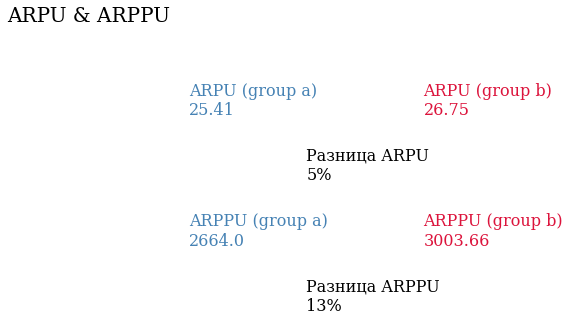

In [9]:
arpu_by_group = round(df2 \
    .groupby('testgroup', as_index = False) \
    .agg({'revenue' : 'mean'}), 2)

arppu_by_group = round(df2 \
    .query('revenue > 0') \
    .groupby('testgroup', as_index = False) \
    .agg({'revenue' : 'mean'}), 2)

plt.figure()
plt.text(s = f'''ARPU (group a) 
{arpu_by_group['revenue'][0]}''',
           color = 'steelblue',
           fontsize = 16,
           x = 0.5,
           y = 0.8,
           family = 'serif')

plt.text(s = f'''ARPU (group b) 
{arpu_by_group['revenue'][1]}''',
           color = 'crimson',
           fontsize = 16,
           x = 1.2,
           y = 0.8,
           family = 'serif')

plt.text(s = f'''Разница ARPU
{round(abs((arpu_by_group['revenue'][0]-arpu_by_group['revenue'][1]) / arpu_by_group['revenue'][0] * 100))}%''',
           color = 'black',
           fontsize = 16,
           x = 0.85,
           y = 0.5,
           family = 'serif')

plt.text(s = f'''ARPPU (group a) 
{arppu_by_group['revenue'][0]}''',
           color = 'steelblue',
           fontsize = 16,
           x = 0.5,
           y = 0.2,
           family = 'serif')

plt.text(s = f'''ARPPU (group b) 
{arppu_by_group['revenue'][1]}''',
           color = 'crimson',
           fontsize = 16,
           x = 1.2,
           y = 0.2,
           family = 'serif')

plt.text(s = f'''Разница ARPPU
{round(abs((arppu_by_group['revenue'][0]-arppu_by_group['revenue'][1]) / arppu_by_group['revenue'][0] * 100))}%''',
           color = 'black',
           fontsize = 16,
           x = 0.85,
           y = -0.1,
           family = 'serif')
plt.axis('off')

plt.title(label = 'ARPU & ARPPU',
          color = 'black',
          fontsize = 20,
          x = 0.2,
          y = 1.2,
          family = 'serif')

plt.show()

Чтобы определить имеется ли стат. значимая разница ARPU\ARPPU между группами будем использовать t-test и bootstrap (mean).

t-test ARPU

In [10]:
alpha = 0.05
p = stats.ttest_ind(df2.query("testgroup == 'a'")['revenue'], df2.query("testgroup == 'b'")['revenue'], 
                    equal_var = False)[1]
print(p)
if p < alpha:
    print('Нулевая гипотеза о равенстве средних отклонена')
else:
    print('Нулевая гипотеза о равенстве средних не отклонена')

0.5329647014130866
Нулевая гипотеза о равенстве средних не отклонена


bootstrap ARPU

In [11]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    print('p-value = ', p_value)
    
boodet_data_mean = get_bootstrap(
    data_column_1 = df2.query("testgroup == 'a'")['revenue'], 
    data_column_2 = df2.query("testgroup == 'b'")['revenue'], 
    boot_it = 1000, 
    statistic = np.mean, 
     bootstrap_conf_level = 0.95 
)

p-value =  0.5126441264702019


Различия в акционных наборах не оказали влияние на ARPU

ARPPU t-test

In [12]:
p = stats.ttest_ind(df2.query("testgroup == 'a' & revenue > 0")['revenue'], df2.query("testgroup == 'b' & revenue > 0")['revenue'], 
                    equal_var = False)[1]
print(p)
if p < alpha:
    print('Нулевая гипотеза о равенстве средних отклонена')
else:
    print('Нулeвая гипотеза о равенстве средних не отклонена')

0.10020780398916015
Нулeвая гипотеза о равенстве средних не отклонена


bootstrap ARPPU

In [13]:
boodet_data_mean = get_bootstrap(
    data_column_1 = df2.query("testgroup == 'a' & revenue > 0")['revenue'], 
    data_column_2 = df2.query("testgroup == 'b' & revenue > 0")['revenue'], 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 )

p-value =  0.08545597250602385


нулевая гипотеза не отклонена

Различия в акционных наборах не оказали влияние на ARРPU

сравним конверсию по группам

In [17]:
purchases = []
for i in df2['revenue']:
    if i == 0:
        x = 'no'
    else:
        x = 'yes'
    purchases.append(x)
df2['purchase'] = purchases



group_test = df2 \
    .groupby(['purchase', 'testgroup'], as_index = False) \
    .agg({'user_id' : 'count'}) \


In [18]:
group_test

,purchase,testgroup,user_id
0,no,a,200175
1,no,b,200862
2,yes,a,1928
3,yes,b,1805


доход несильно между группами отличается

конверсия покупок а группы

In [22]:
1928/200175*100

0.9631572374172599

конверсия покупок б группы

In [23]:
1805/200862*100

0.898626917983491

не сильно различаются

In [19]:
df2

,user_id,revenue,testgroup,purchase
0,1,0,b,no
1,2,0,a,no
2,3,0,a,no
3,4,0,b,no
4,5,0,b,no
...,...,...,...,...
404765,404766,0,a,no
404766,404767,0,b,no
404767,404768,231,a,yes
404768,404769,0,a,no


исходя из полученных результатов,  считаю, что для глубокого понимания различий нужно больше данных.
так как исходя из полученных результатов нельзя сказать, что конверсии сильно различаются и как следствие выделить каую-то тестовую группу

## 3 задание


В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Ключевые метрики - удержание и конверсия
Так же
 - MAU и DAU. Соответственно ежемесячно и ежедневно активные пользователи
 - средняя длина сессии на одного пользователя (Session — это время, которое пользователь провел в мобильном приложении. ASD — Average Session Duration — это среднее время сессий за период времени)
 
В усложненом случае можно будет ввести показатель "ухода" пользователей после отката на несколько уровне. В целом будет отдельная группа для исследования - те, у которых были неудачные попытки выполнения уровней и какая у них конверсия